# Preparing enviroment

In [3]:
!rm /kaggle/working/1NwcwlWqA-0HqAPk3dSNNPipGMF0iS0Zu

In [24]:
import warnings
warnings.filterwarnings('ignore')
!pip -q install opendatasets
!pip -q install pandas
!pip -q install darknet
!pip -q install numba

In [25]:
import opendatasets as od
import pandas

# od.download(
#     "https://mm.cs.uec.ac.jp/uecfoodpix/UECFOODPIXCOMPLETE.tar")

In [ ]:
! tar xf /kaggle/working/UECFOODPIXCOMPLETE.tar
! rm /kaggle/working/UECFOODPIXCOMPLETE.tar

# importes

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import pydot
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
from tensorflow import keras
from keras import layers
from os import path
import imageio



import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import Sequence


# Directories

In [2]:
DRIVE_FOLDER = "/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE"
SUBSET_FOLDER = ""

TRAIN_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/img")
TRAIN_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/mask")

TEST_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/img")
TEST_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/mask")

# Settings

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 100

CLASSES = 103

# Loading data

In [4]:
base_dir = "/kaggle/working/UECFOODPIXCOMPLETE/data" 
train_images = sorted(glob(str(TRAIN_IMAGE_DIR/'*.jpg')))
train_masks = sorted(glob(str(TRAIN_MASK_DIR/'*.png')))

val_images = sorted(glob(str(TEST_IMAGE_DIR/'*.jpg')))
val_masks = sorted(glob(str(TEST_MASK_DIR/'*.png')))

print(len(train_images))
print(len(val_images))

9000
1000


# Visualize data

(Array([  0,  97, 102, 255], dtype=uint8), array([866400,  44646,  10554, 307200]))
(Array([  0,  95, 101, 102, 255], dtype=uint8), array([480402,  22229,  22531,   5838, 177000]))
(Array([  0,  36,  82, 102, 255], dtype=uint8), array([584840,  10447,  38347,  14366, 216000]))


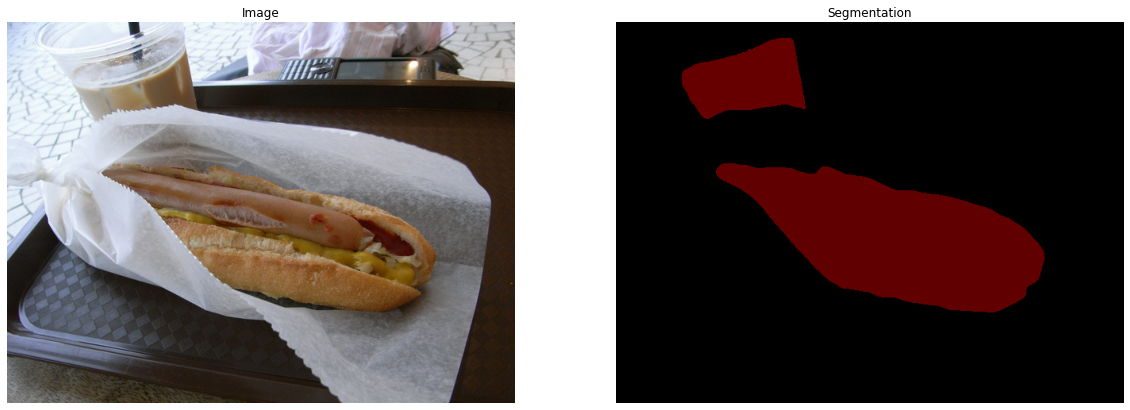

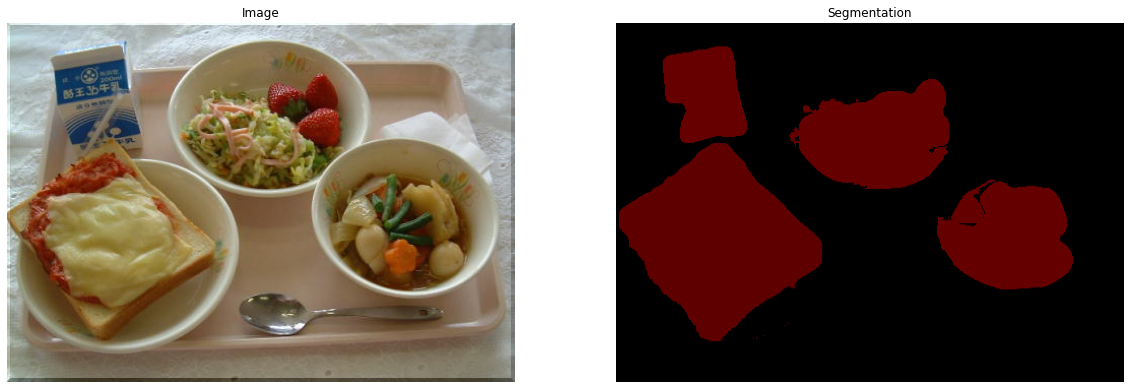

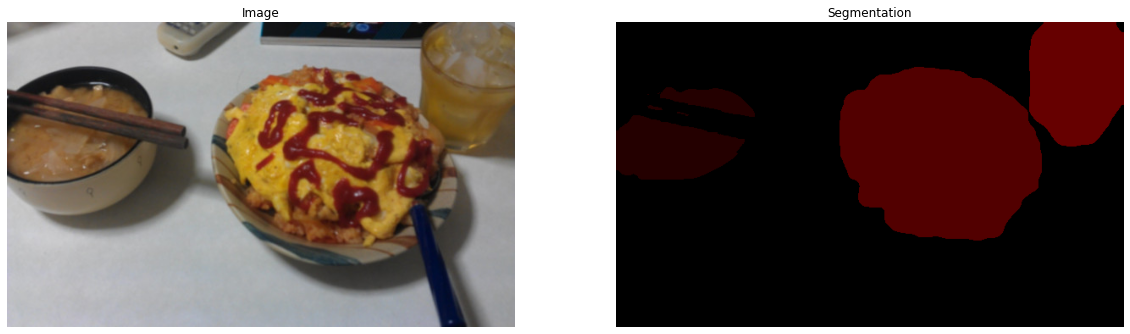

In [5]:
import random
number_of_samples = len(train_images)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(train_images[N])
    mask = imageio.imread(train_masks[N])
    
    fig, arr = plt.subplots(1, 2, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    print(np.unique(mask, return_counts=True))

# Generating Dataset

In [ ]:
class UECFoodPIXGenerator(Sequence):
    def __init__(self, dataset_dir, image_size=(320, 320), batch_size=16, mode='train'):
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.mode = mode
        self.image_dir = os.path.join(dataset_dir, 'UECFoodPIXCOMPLETE/train' if mode == 'train' else 'UECFoodPIXCOMPLETE/test', 'img')
        self.mask_dir = os.path.join(dataset_dir, 'UECFoodPIXCOMPLETE/train' if mode == 'train' else 'UECFoodPIXCOMPLETE/test', 'mask')
        self.category_file = os.path.join(dataset_dir, 'category.txt')
        self.data_file = os.path.join(dataset_dir, 'train9000.txt' if mode == 'train' else 'test1000.txt')
        self.categories = pd.read_csv('/kaggle/working/UECFOODPIXCOMPLETE/data/category.txt', sep='\t')['name']
        self.data = self.load_data()
        self.num_classes = len(self.categories)
        
    def load_data(self):
        data = []
        with open(self.data_file, 'r') as f:
            for line in f:
                filename = line.strip()
                data.append(filename + ".jpg")
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = np.zeros((len(batch_data), self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_data), self.image_size[0], self.image_size[1], 1), dtype=np.float32)
    
        for i, filename in enumerate(batch_data):
            image_path = os.path.join(self.image_dir, filename)
            mask_path = os.path.join(self.mask_dir, filename.replace('.jpg', '.png'))
            
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, self.image_size, method='nearest')

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=3)
            mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
            mask = tf.image.resize(mask, self.image_size, method='nearest')
            
            batch_images[i] = image.numpy()
            batch_masks[i] = mask.numpy()
        return batch_images, batch_masks
    
    def on_epoch_end(self):
        np.random.shuffle(self.data)


In [ ]:
train_dataset = UECFoodPIXGenerator(base_dir, image_size=(320, 320), batch_size=16, mode='train')
validation_dataset = UECFoodPIXGenerator(base_dir, image_size=(320, 320), batch_size=16, mode='test')
train_dataset

In [6]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')
    
    return image, mask

In [7]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [8]:
train_dataset = data_generator(train_images, train_masks, BUFFER_SIZE, BATCH_SIZE)
validation_dataset = data_generator(val_images, val_masks, BUFFER_SIZE, 2)

print(train_dataset)
print(validation_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>


In [ ]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

In [ ]:
for i in range(5):
    num = np.random.randint(0, len(train_dataset))
    image, mask = train_dataset[num]
    plot2x2Array(image[0], mask[0])

# Visualization callback

In [9]:
# Visualization callback to see how mask prediction progresses.
class MaskCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_mask_predictions(validation_dataset,1)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [10]:
def plot_mask_predictions(dataset, examples=1):
    plt.figure(figsize=(21, 7 * examples))

    for i, (image, mask) in enumerate(dataset.take(examples)):
        ax = plt.subplot(examples, 3, 3*i+1)
        plt.imshow(image[0])
        plt.axis("off")

        ax = plt.subplot(examples, 3, 3*i+2)
        print(np.unique(mask[0].numpy().astype("uint8").squeeze(axis=2)))
        plt.imshow(mask[0].numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(mask[0]))
        plt.axis("off")


        pred_mask = create_mask(model.predict(image))

        ax = plt.subplot(examples, 3, 3*i+3)
        plt.imshow(pred_mask.numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(pred_mask))
        plt.axis("off")

    plt.show()

# Model

In [11]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [13]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet101(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model

In [17]:
model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=CLASSES)
model.summary()
CLASSES

171458560/171446536 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________

103

In [18]:
EPOCHS = 100
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
learning_rate = 0.001
decay_rate = 0.0005
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"],
)

In [11]:
model = keras.models.load_model('/kaggle/working/cp2.h5')

## Model Training

In [41]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="cp2.h5", 
    verbose=1, 
    save_weights_only=False , monitor='val_loss', save_best_only=True)

early_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

Epoch 1/5
563/563 [==============================] - 159s 278ms/step - loss: 0.7894 - accuracy: 0.8213 - val_loss: 1.0967 - val_accuracy: 0.7280

Epoch 00001: val_loss improved from inf to 1.09667, saving model to cp2.h5
[  0   2 101]


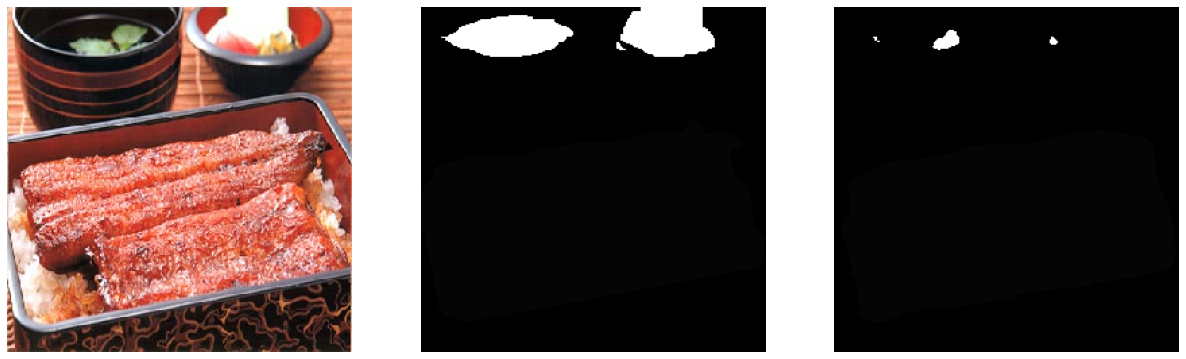

Epoch 2/5
563/563 [==============================] - 156s 277ms/step - loss: 0.7898 - accuracy: 0.8191 - val_loss: 1.0962 - val_accuracy: 0.7280

Epoch 00002: val_loss improved from 1.09667 to 1.09616, saving model to cp2.h5
[  0  90 101]


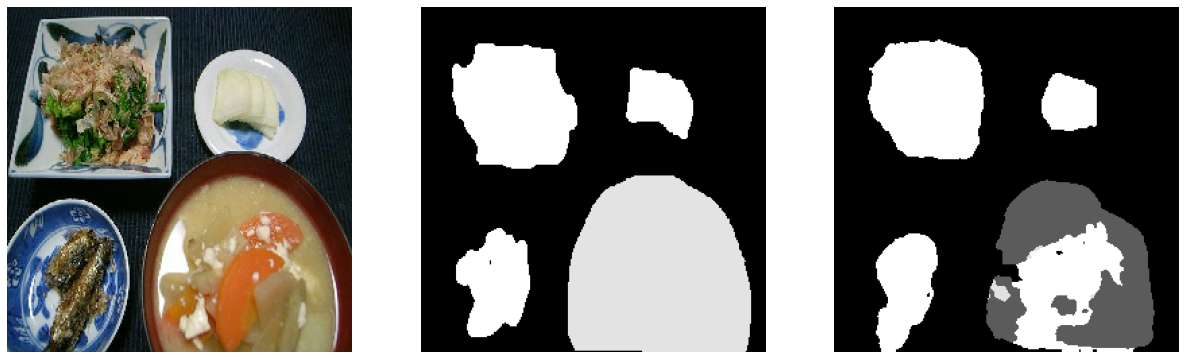

Epoch 3/5
563/563 [==============================] - 156s 277ms/step - loss: 0.7824 - accuracy: 0.8227 - val_loss: 1.0962 - val_accuracy: 0.7280

Epoch 00003: val_loss did not improve from 1.09616
[ 0 87]


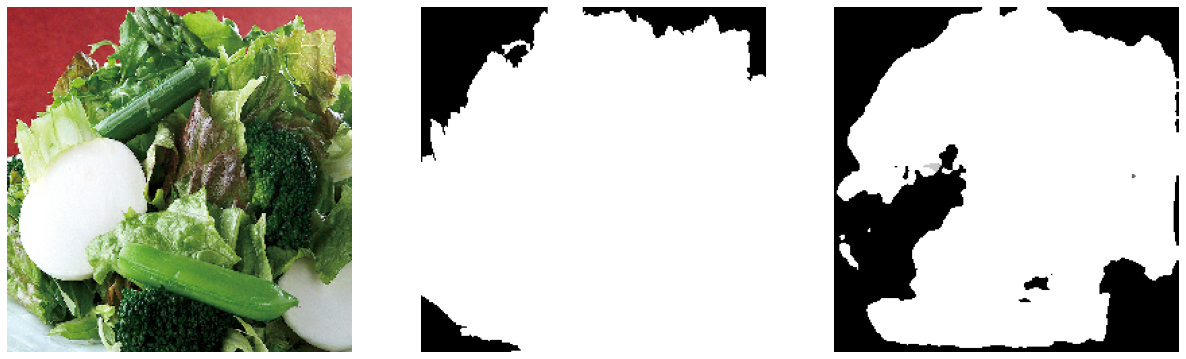

Epoch 4/5
563/563 [==============================] - 156s 277ms/step - loss: 0.7848 - accuracy: 0.8205 - val_loss: 1.0962 - val_accuracy: 0.7279

Epoch 00004: val_loss did not improve from 1.09616
[ 0 12]


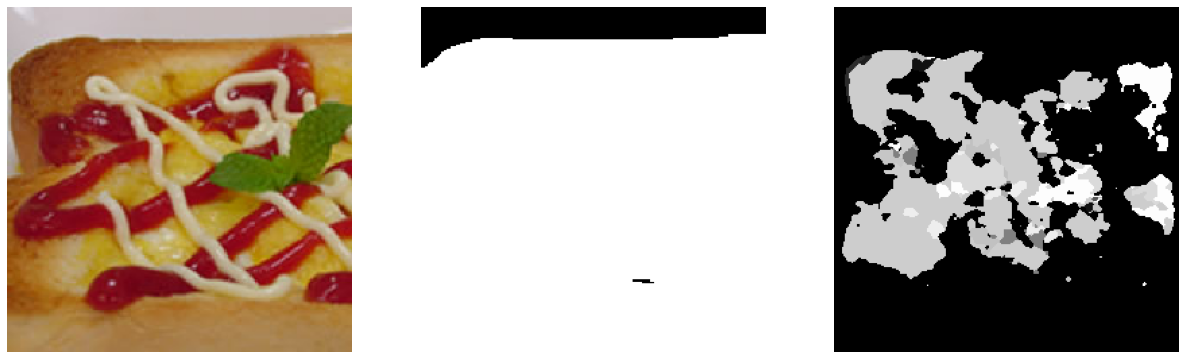

Epoch 5/5
563/563 [==============================] - 156s 277ms/step - loss: 0.7799 - accuracy: 0.8227 - val_loss: 1.0962 - val_accuracy: 0.7279

Epoch 00005: val_loss did not improve from 1.09616
[ 0 12]


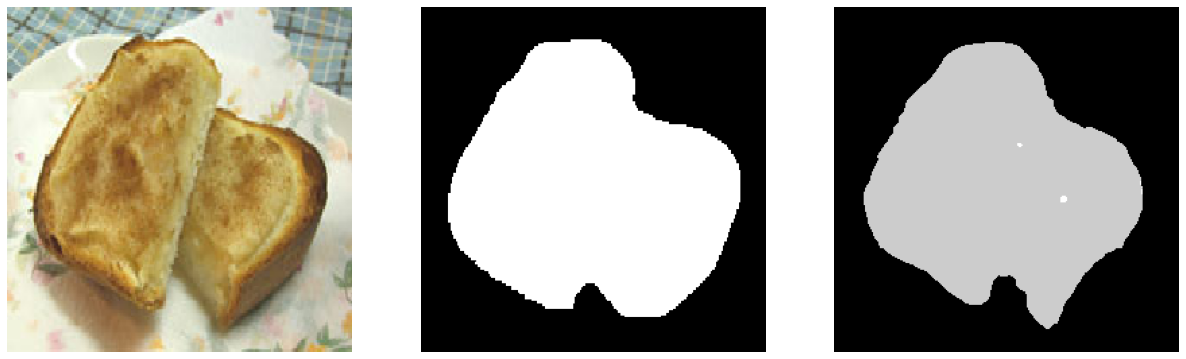

In [42]:
with tf.device("GPU"):
    history = model.fit(train_dataset, 
                        validation_data = validation_dataset, 
                        epochs = 5, 
                        verbose=1, 
                        callbacks=[cp_callback, early_callback, reduce_lr,MaskCallback()])

In [22]:
model.save('model.h5')

# Model Evaluation

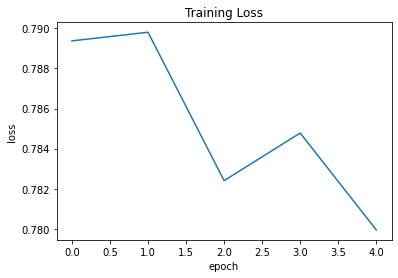

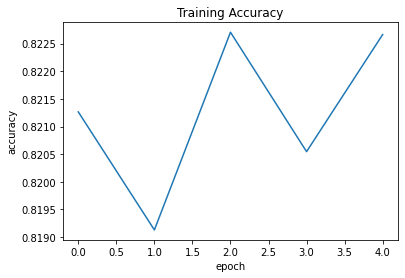

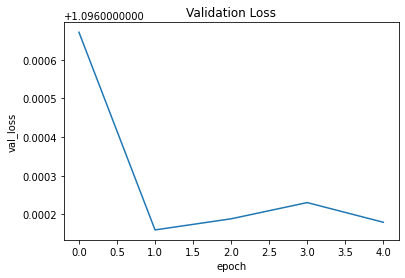

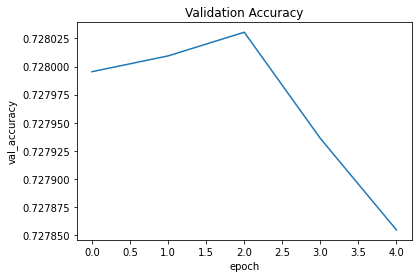

In [43]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [29]:
model = load_model('/kaggle/working/cp2.h5')

In [15]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)

500/500 [==============================] - 14s 27ms/step - loss: 1.0962 - accuracy: 0.7280


In [16]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 87.69%
Model Accuracy on the Validation Dataset: 72.8%


### Intersection-over-Union (IoU)

In [12]:
def iou_score(dataset):
    intersections, unions, max_ious, min_ious = [], [], [], []
    
    for images, masks in dataset:
        pred_mask = model.predict(images)
        intersection = np.logical_and(masks, pred_mask)
        union = np.logical_or(masks, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        batch_iou_score = intersection_sum / union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)
        
        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections) / np.sum(unions)   
    
    return min_iou, max_iou, mean_iou

In [13]:
train_min_iou, train_max_iou, train_mean_iou = iou_score(train_dataset)
validation_min_iou, validation_max_iou, validation_mean_iou = iou_score(validation_dataset)
# test_min_iou, test_max_iou, test_mean_iou = iou_score(test_dataset)

In [14]:
print(f'IoU on the Training Dataset: \n Minimum IoU Score: {round(train_min_iou*100, 2)}% \n Maximum IoU Score: {round(train_max_iou*100, 2)}% \n Mean IoU Score: {round(train_mean_iou*100, 2)}% \n')
print(f'IoU on the Validation Dataset: \n Minimum IoU Score: {round(validation_min_iou*100, 2)}% \n Maximum IoU Score: {round(validation_max_iou*100, 2)}% \n Mean Iou Score: {round(validation_mean_iou*100, 2)}% \n')
# print(f'IoU on the Test Dataset: \n Minimum IoU Score: {round(test_min_iou*100, 2)}% \n Maximum IoU Score: {round(test_max_iou*100, 2)}% \n Mean IoU Score: {round(test_mean_iou*100, 2)}% \n')

IoU on the Training Dataset: 
 Minimum IoU Score: 4.68% 
 Maximum IoU Score: 100.0% 
 Mean IoU Score: 44.25% 

IoU on the Validation Dataset: 
 Minimum IoU Score: 6.0% 
 Maximum IoU Score: 100.0% 
 Mean Iou Score: 44.2% 



## Predict image segmentations using the trained Model

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [16]:
def show_predictions(dataset, num):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

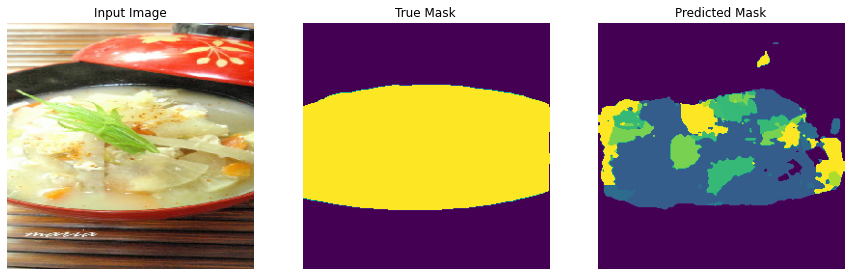

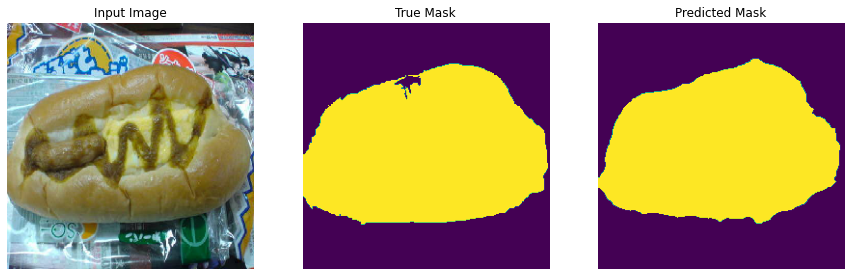

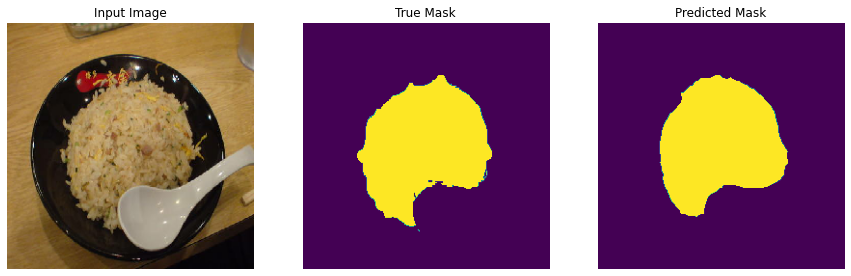

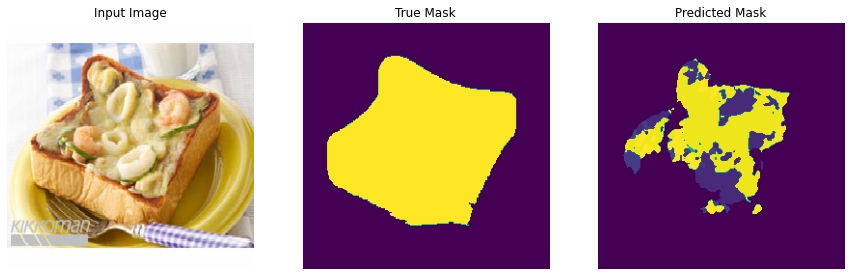

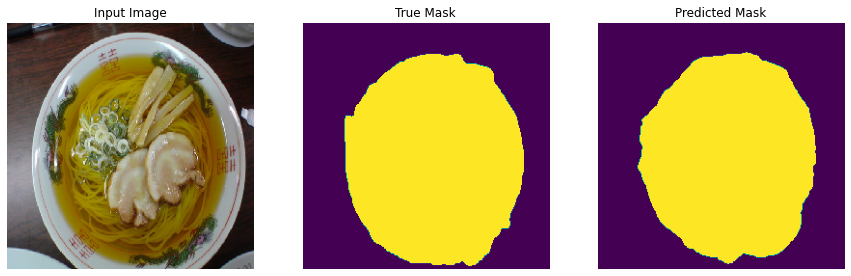

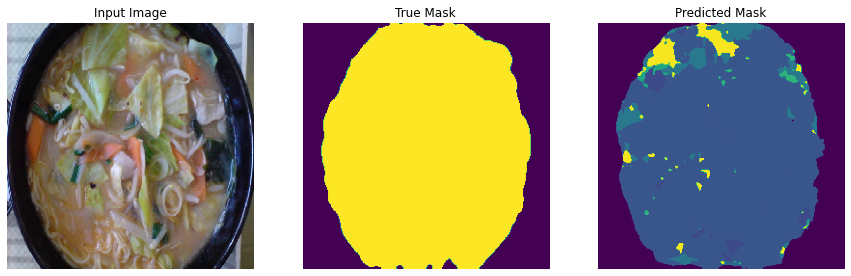

In [18]:
show_predictions(validation_dataset, 6)

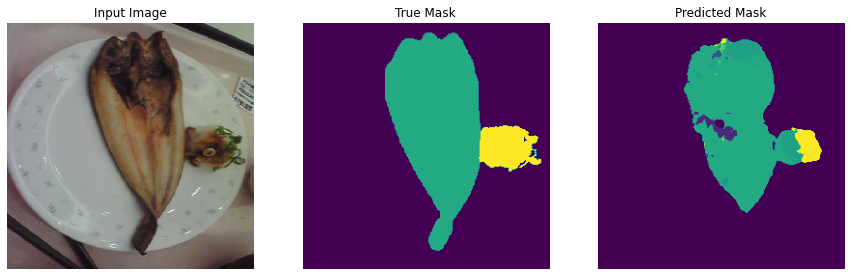

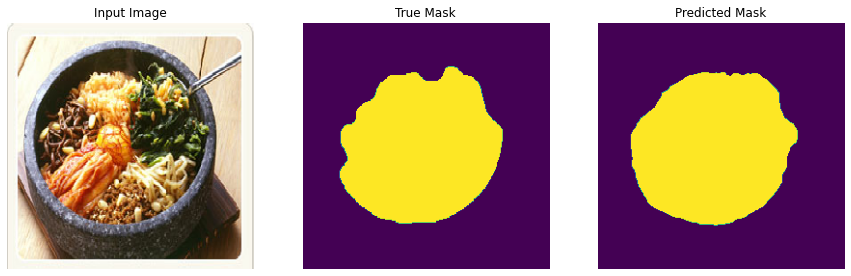

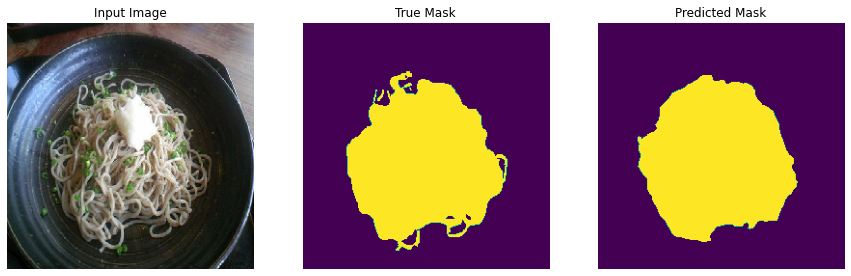

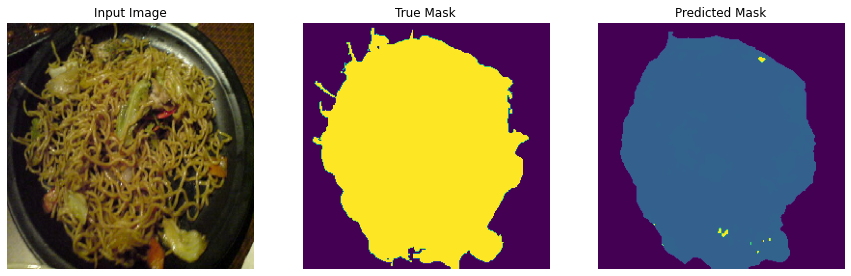

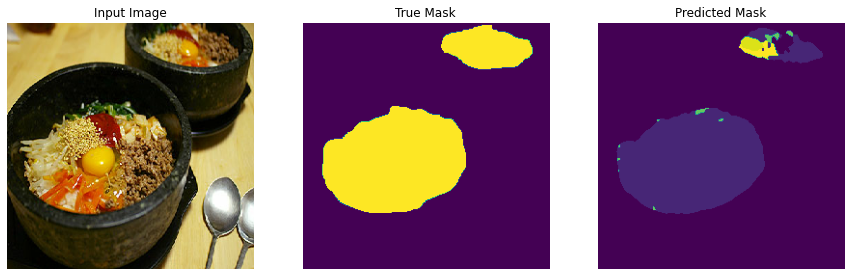

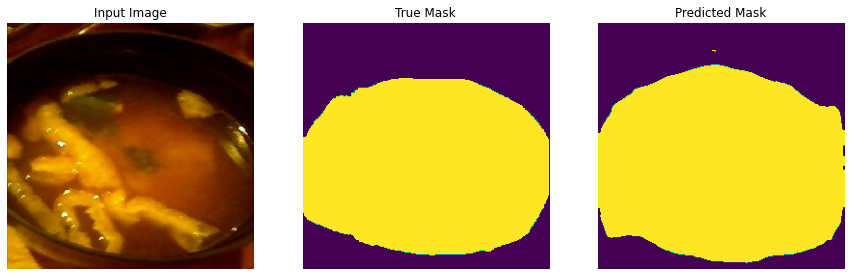

In [19]:
show_predictions(train_dataset, 6)

In [ ]:
# Define a function to read the category file and return a dictionary mapping IDs to names
def read_category_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    category_dict = {}
    for line in lines[1:]:
        category_id, category_name = line.strip().split('\t')
        category_dict[int(category_id)] = category_name
    return category_dict